# Using Financial Data to Predict Bankruptcy 

### Data Source: https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction 

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import metrics  

In [13]:
def xlsx(Data_frame, outfile): 
    writer = pd.ExcelWriter(outfile, engine = 'xlsxwriter')
    Data_frame.to_excel(writer, sheet_name = 'sheet_1', index = False)
    writer.close()

### Loading Data and Pre-processing 

In [14]:
df = pd.read_csv('data/Taiwan_bankruptcy.csv')
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


## Feature Datatypes 
#### Bankrupt? - categorical (binary), all other data is continuous.

In [15]:
# Counting number of positive and negative instances 
pos = 0
neg = 0
for value in df['Bankrupt?'].values:
    if value == 0:
        neg +=1
    else:
        pos +=1 

print(f'positives: {pos}, negatives: {neg}')

positives: 220, negatives: 6599


In [16]:
# Separating data and target vector  
X = df.drop(['Bankrupt?'], axis=1)
y = df.loc[:, ['Bankrupt?']] 

# mean scale data 
mean = np.mean(X.T, axis = 1)
standard_scaler = StandardScaler()
X_scaled = pd.DataFrame(standard_scaler.fit_transform(X), columns = X.columns)

## Feature selection: 

In [17]:
# ANOVA feature selection 
selector = feature_selection.SelectKBest(k = 10)
X_new = selector.fit_transform(X_scaled, y)
feats_used = selector.get_support().tolist()
features = X_scaled.columns.tolist()
K_best_selections = [features[i] for i in range(0,94) if feats_used[i] == True]

# Dropping unused features 
features = K_best_selections
bad_feats = [feature for feature in X_scaled.columns.tolist() if feature not in features]
X_opt = X_scaled.drop(columns=bad_feats)

summary_stats = X_opt.describe()
summary_stats.drop(['count', 'min', '25%', '50%', '75%', 'max'], axis=0, inplace=True)
summary_stats = summary_stats.transpose()
#xlsx(summary_stats, 'data/used_feature_summary.xlsx')

/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


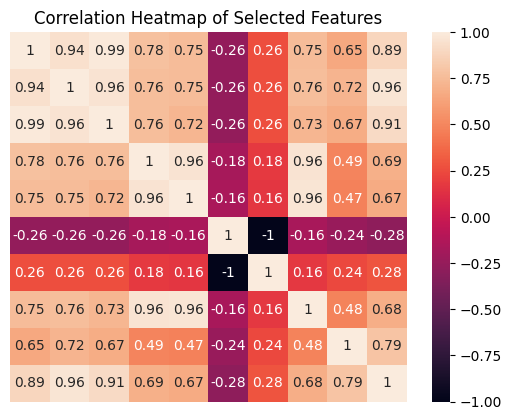

In [18]:
# Heatmap of showing correlation of selected variables 
sns.heatmap(X_opt.corr(), annot=True, yticklabels=False, xticklabels=False)
plt.title("Correlation Heatmap of Selected Features")
plt.tick_params(left=False, bottom=False)
#plt.savefig('figures/heatmap.pdf', bbox_inches='tight')

## Model Construction

In [19]:
# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size=0.2, random_state=100, stratify=y)

### Logistic Regression hyperparameter tuning 

In [20]:
# conducting grid searches to optimise the Logistic Regression hyperparameters 

logistic_regression = linear_model.LogisticRegression()

scorer = metrics.make_scorer(metrics.f1_score) # using f1 score to rank combinations

# Define the parameter grid to search with solvers that support L1 and L2 regularisation 
both_reg_param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
}

both_grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=both_reg_param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=5), 
    verbose=1,
    n_jobs=-1,  
)

# Fit the grid search to the data
both_grid_search.fit(X_train, y_train)
print("L1 and L2 result:")
print("Best Parameters:", both_grid_search.best_params_)
print("Best F1 Score:", both_grid_search.best_score_)

# Evaluate the best model on the test set
best_model = both_grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_f1_score = metrics.f1_score(y_test, test_predictions)
print("Test F1 Score:", test_f1_score)

# Define the parameter grid to search with solvers that only support L2 regularisation 
param_grid = {
    'penalty': ['l2'],  # Only L2 regularization
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'solver': ['newton-cg', 'lbfgs', 'sag'],  # Solvers that support L2 regularization
}

L2_grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=5), 
    verbose=1,
    n_jobs=-1,  
)

# Fit the grid search to the data
L2_grid_search.fit(X_train, y_train)
print("L2 reults:")
print("Best Parameters:", L2_grid_search.best_params_)
print("Best F1 Score:", L2_grid_search.best_score_)

# Evaluate the best model on the test set
best_model = L2_grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_f1_score = metrics.f1_score(y_test, test_predictions)
print("Test F1 Score:", test_f1_score)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

L1 and L2 result:
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score: 0.2922746648066341
Test F1 Score: 0.19999999999999998
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

L2 reults:
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1 Score: 0.2922746648066341
Test F1 Score: 0.19999999999999998


/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

### Comparing balanced and unbalanced Logistic Regression 

In [21]:
def calculate_metrics(y_true, y_pred):
    # Calculate True Positives, False Positives, False Negatives, and True Negatives
    cm = metrics.confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # Calculate Precision, Recall, and Negative Predictive Value (NPV)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score, precision, recall

In [22]:
UB_model = linear_model.LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
B_model = linear_model.LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)

UB_model.fit(X_train, y_train) 
B_model.fit(X_train, y_train)

UB_y_pred = UB_model.predict(X_test)
B_y_pred = B_model.predict(X_test) 

UB_pred_prob = UB_model.predict_proba(X_test)[:, 1]
B_pred_prob = B_model.predict_proba(X_test)[:, 1]

UB_f1, UB_precision, UB_recall = calculate_metrics(y_test, UB_y_pred)
B_f1, B_precision, B_recall = calculate_metrics(y_test, B_y_pred)

results = {
    'Model': ['Unbalanced CV Logistic Regression', 'Balanced CV Logistic Regression'],
    'F1 Score': [UB_f1, B_f1], 
    'AUC': [metrics.roc_auc_score(y_test, UB_pred_prob), metrics.roc_auc_score(y_test, B_pred_prob)], 
    'Precision': [UB_precision, B_precision], 
    'Recall': [UB_recall, B_recall]
    
}
UB_B_LR = pd.DataFrame.from_dict(results)
#xlsx(UB_B_LR, 'data/UB_B_LR.xlsx')

/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Hyperparameter tuning for Balanced BAgged Logistic Regression  

/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/user/anaconda3/lib/python3.11/s

[0.25547445255474455, 0.2690909090909091, 0.26277372262773724, 0.26277372262773724, 0.26666666666666666, 0.2716981132075472, 0.2696629213483146, 0.27067669172932335, 0.2696629213483146, 0.27067669172932335]


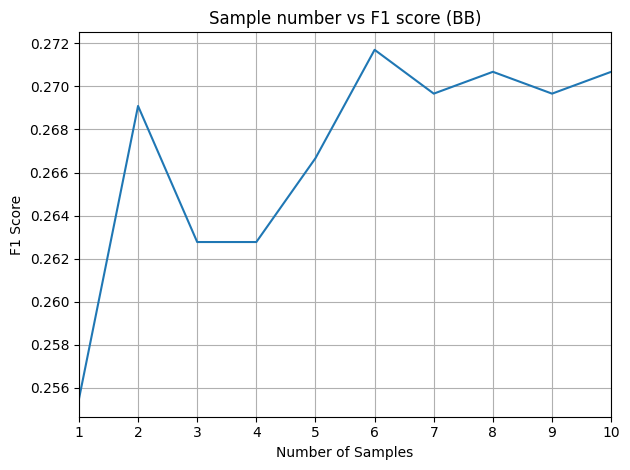

In [23]:
# finding the optimum number of base learners for BB
base_learner = linear_model.LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
results = []
samples = [i for i in range(1, 11)]
for i in range(1, 11):
    model = BalancedBaggingClassifier(base_estimator=base_learner, n_estimators=i, sampling_strategy='auto', replacement=False, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = metrics.f1_score(y_test, y_pred)
    results.append(f1)

print(results)
plt.plot(samples, results)
plt.title("Sample number vs F1 score (BB)")
plt.xlabel("Number of Samples")
plt.ylabel("F1 Score")
plt.xlim(1, 10)
plt.tight_layout()
plt.grid()
#plt.savefig("figures/BB_samples.jpeg")


### Fitting the optimised models

In [24]:
# defining the models
CV_model = linear_model.LogisticRegressionCV(Cs=10, penalty='l2', solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)

BB_model = BalancedBaggingClassifier(base_estimator=base_learner, n_estimators=6, sampling_strategy='auto', replacement=False, random_state=42)

In [25]:
# fitting the models 
CV_model.fit(X_train, y_train)
BB_model.fit(X_train, y_train)

# making predictions 
CV_y_pred = CV_model.predict(X_test)
BB_y_pred = BB_model.predict(X_test)

/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


## Model Evaluation 

In [26]:
CV_f1, CV_precision, CV_recall = calculate_metrics(y_test, CV_y_pred)
BB_f1, BB_precision, BB_recall = calculate_metrics(y_test, BB_y_pred)

CV_pred_prob = CV_model.predict_proba(X_test)[:, 1]
BB_pred_prob = BB_model.predict_proba(X_test)[:, 1]

# Exporting results 
results = {
    'Model': ['5-Fold Cross Validated Logistic Regression', 'Balanced BAgged'],
    'F1 Score': [CV_f1, BB_f1], 
    'AUC': [metrics.roc_auc_score(y_test, CV_pred_prob), metrics.roc_auc_score(y_test, BB_pred_prob)],
    'Precision': [CV_precision, BB_precision], 
    'Recall': [CV_recall, BB_recall]
}

resultsDF = pd.DataFrame.from_dict(results)
#xlsx(resultsDF, 'data/final_results.xlsx')

### Visualisations 

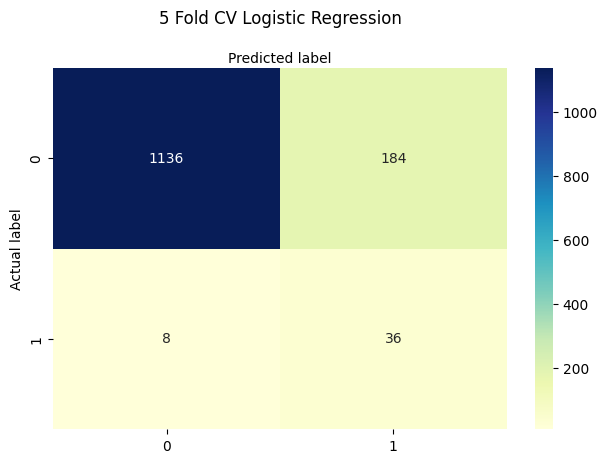

In [27]:
# Cross validated Logistic Regression 
cnf_matrix = metrics.confusion_matrix(y_test, CV_y_pred)

class_names=["Not Bankrupt", "Bankrupt"] # name  of classes 
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)  
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('5 Fold CV Logistic Regression', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig('figures/CV_conf.pdf')

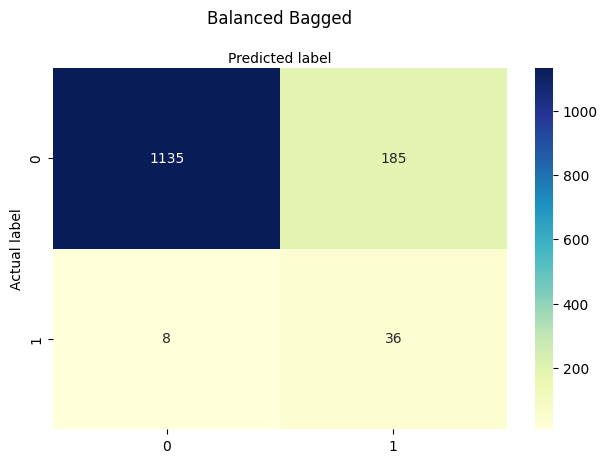

In [28]:
# Balanced BAgged Logistic Regression 
cnf_matrix = metrics.confusion_matrix(y_test, BB_y_pred)

class_names=["Not Bankrupt", "Bankrupt"] # name  of classes 
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)  
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Balanced Bagged', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig('figures/BB_conf.pdf')

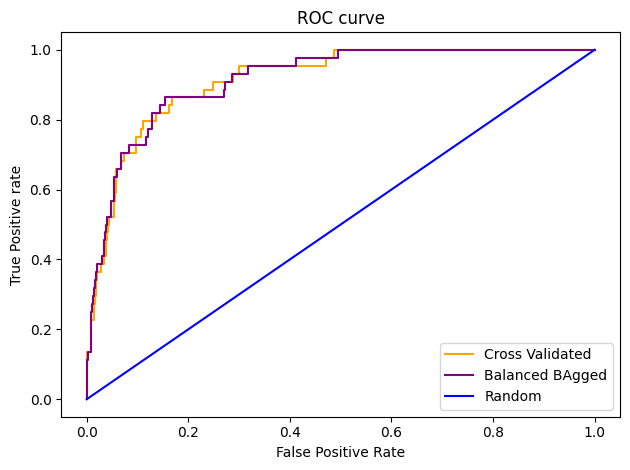

In [29]:
# Plotting ROC curves for each model 
CV_pred_prob = CV_model.predict_proba(X_test)
CV_fpr, CV_tpr, CV_thresholds = metrics.roc_curve(y_test, CV_pred_prob[:,1], pos_label=1)

BB_pred_prob = BB_model.predict_proba(X_test)
BB_fpr, BB_tpr, BB_thresholds = metrics.roc_curve(y_test, BB_pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
CV_p_fpr, CV_p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
BB_p_fpr, BB_p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)

plt.plot(CV_fpr, CV_tpr, linestyle='-', color='orange', label='Cross Validated')
plt.plot(BB_fpr, BB_tpr, linestyle='-', color='purple', label='Balanced BAgged')
plt.plot(CV_p_fpr, CV_p_tpr, linestyle='-', color='blue', label='Random')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.tight_layout()
#plt.savefig('figures/ROC.jpeg')